In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [132]:
class KohonenNetwork:
    def __init__(self, M, N, input_dim):
        self.M = M
        self.N = N
        self.input_dim = input_dim
        self.weights = np.random.rand(M, N, input_dim)

    def gaussian_neighborhood(self, x, y, sigma, lambda_decay, t):
        s = sigma * np.exp(-t / lambda_decay)
        for i in range(self.M):
            for j in range(self.N):
                distance = (i - x) ** 2 + (j - y) ** 2
                yield np.exp(-distance / (2 * s ** 2))

    def mexican_hat(self, x, y, sigma, lambda_decay, t):
        s = sigma * np.exp(-t / lambda_decay)
        for i in range(self.M):
            for j in range(self.N):
                distance = (i - x) ** 2 + (j - y) ** 2
                r = np.sqrt(distance)
                yield (2 - (r / s) ** 2) * np.exp(-r ** 2 / (2 * s ** 2))

    def train(self, data, num_epochs=100, learning_rate=0.1, sigma=1.0, lambda_decay=100):
        for t in range(num_epochs):
            for input_vector in data:
                # Ensure that input_vector is at least a 1D array
                if input_vector.ndim == 0:
                    input_vector = np.array([input_vector])
                elif input_vector.ndim == 1:
                    input_vector = input_vector[np.newaxis, :]

                # # Logging for debugging
                # print(f"Input vector dimensions: {input_vector.shape}")
                # print(f"Weight dimensions: {self.weights.shape}")

                # Calculating distances
                distances = np.linalg.norm(self.weights - input_vector, axis=2)
                winner_index = np.unravel_index(np.argmin(distances), distances.shape)

                # Updating weights
                neighborhood = self.gaussian_neighborhood(*winner_index, sigma, lambda_decay, t)
                for i in range(self.M):
                    for j in range(self.N):
                        influence = next(neighborhood)
                        self.weights[i, j, :] += learning_rate * influence * (input_vector.flatten() - self.weights[i, j, :])

    def visualize(self):
        if self.input_dim == 2:
            plt.figure(figsize=(8, 8))
            for i in range(self.M):
                for j in range(self.N):
                    plt.scatter(*self.weights[i, j], marker='o', c='r', s=100)
            plt.title('Visualization of 2D Kohonen Network Weights')
            plt.xlabel('Dimension 1')
            plt.ylabel('Dimension 2')
            plt.grid(True)
            plt.show()
        elif self.input_dim == 3:
            fig = plt.figure(figsize=(8, 8))
            ax = fig.add_subplot(111, projection='3d')
            for i in range(self.M):
                for j in range(self.N):
                    ax.scatter(*self.weights[i, j], marker='o', c='r', s=100)
            ax.set_title('Visualization of 3D Kohonen Network Weights')
            ax.set_xlabel('Dimension 1')
            ax.set_ylabel('Dimension 2')
            ax.set_zlabel('Dimension 3')
            plt.show()

    def get_weights(self):
        return self.weights
    
    def quantization_error(self, data):
        error = 0
        for input_vector in data:
            distances = np.linalg.norm(self.weights - input_vector, axis=2)
            error += np.min(distances)
        return error / len(data)


    def u_matrix(self):
        umat = np.zeros((self.M, self.N))
        for i in range(self.M):
            for j in range(self.N):
                neighbors = []
                if i > 0:
                    neighbors.append(self.weights[i-1, j])
                if i < self.M - 1:
                    neighbors.append(self.weights[i+1, j])
                if j > 0:
                    neighbors.append(self.weights[i, j-1])
                if j < self.N - 1:
                    neighbors.append(self.weights[i, j+1])
                
                umat[i, j] = np.mean([np.linalg.norm(self.weights[i, j] - neighbor) for neighbor in neighbors])
        plt.imshow(umat, cmap='gray')
        plt.colorbar()
        plt.title('U-Matrix')
        plt.show()

    def find_bmu(self, input_vector):
        distances = np.linalg.norm(self.weights - input_vector, axis=2)
        return np.unravel_index(np.argmin(distances), distances.shape)

    def cluster_purity(self, data):
        cluster_labels = { (i, j): [] for i in range(self.M) for j in range(self.N) }
        for input_vector in data:
            input_data, label = input_vector[:-1], input_vector[-1]
            bmu = self.find_bmu(input_data)
            cluster_labels[bmu].append(label)
        cluster_identity = {}
        for key, labels in cluster_labels.items():
            if labels:
                most_common_label = max(set(labels), key=labels.count)
                cluster_identity[key] = most_common_label
            else:
                cluster_identity[key] = None
        correct_assignments = sum(1 for input_vector in data if cluster_identity[self.find_bmu(input_vector[:-1])] == input_vector[-1])
        return correct_assignments / len(data), cluster_identity


In [ ]:
def convert_to_numeric(df):
    for column in df.columns[:-1]:  # Przeglądamy wszystkie kolumny oprócz ostatniej
        df[column] = pd.to_numeric(df[column], errors='coerce')  # 'coerce' zamienia błędy na NaN
    return df.dropna()  # Usuń wiersze z NaN

In [149]:
def convert_to_numeric(df):
    for column in df.columns[:-1]:  # Przeglądamy wszystkie kolumny oprócz ostatniej
        df[column] = pd.to_numeric(df[column], errors='coerce')  # 'coerce' zamienia błędy na NaN
    return df.dropna()  # Usuń wiersze z NaN

In [165]:
def load_data(filename):
    data = pd.read_csv(filename, header=None)
    data = convert_to_numeric(data)
    
    # Zliczanie wartości NaN
    nan_count = data.isna().sum().sum()
    print(f"Liczba wartości NaN: {nan_count}")
    
    # Usuwanie wartości NaN
    data = data.dropna()
    
    return data.to_numpy()

In [186]:
hexagon = load_data('../data/hexagon.csv')
cube = load_data('../data/cube.csv')

Liczba wartości NaN: 0
Liczba wartości NaN: 0


In [187]:
data_hex = hexagon[:, :-1]
data_hex = data_hex.astype(float)
data_cube = cube[:, :-1]
data_cube = data_cube.astype(float)

In [189]:
# Przykładowe wywołanie
network = KohonenNetwork(M=20, N=20, input_dim=2)
network.train(data_hex, learning_rate=0.1)

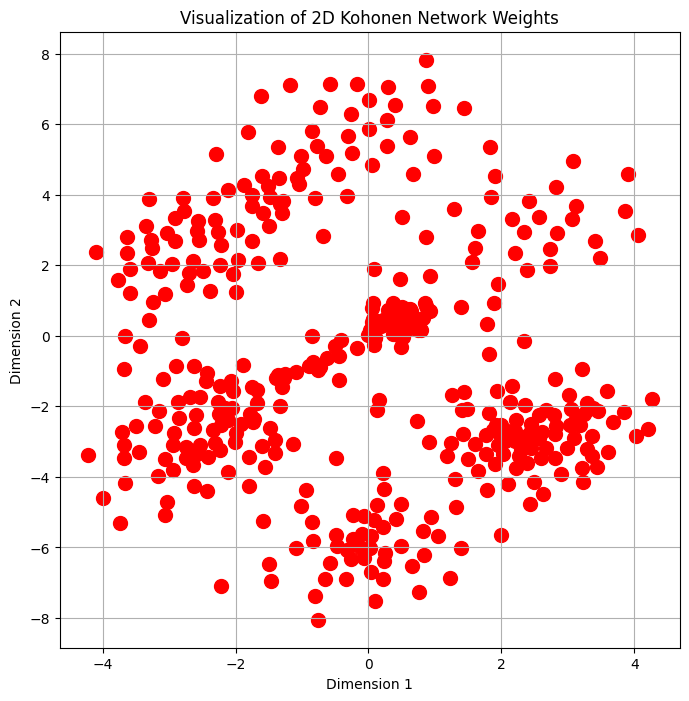

In [190]:
network.visualize()

In [171]:
network_3d = KohonenNetwork(M=10, N=10, input_dim=3)
network_3d.train(data_cube)

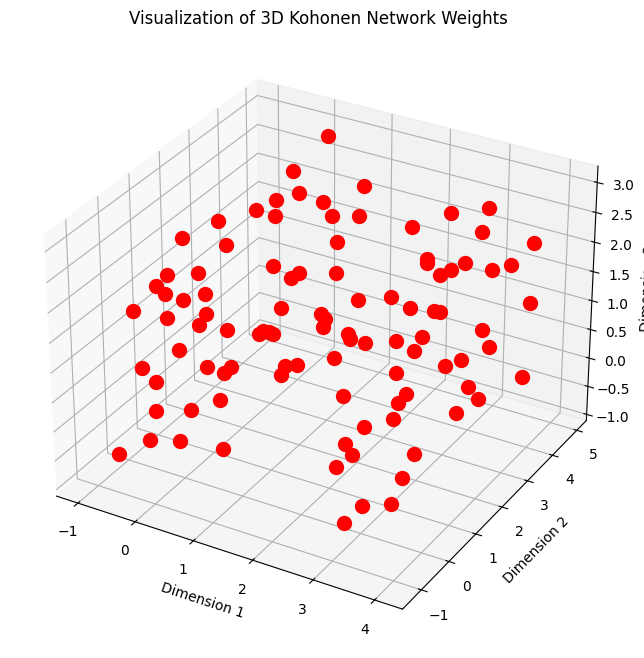

In [172]:
network_3d.visualize()

Quantization Error for 2D network: 0.13059414292815685
Quantization Error for 3D network: 0.44169369837979633
U-Matrix for 2D network:


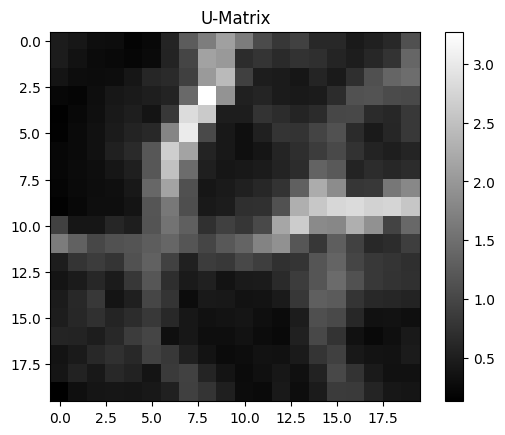

U-Matrix for 3D network:


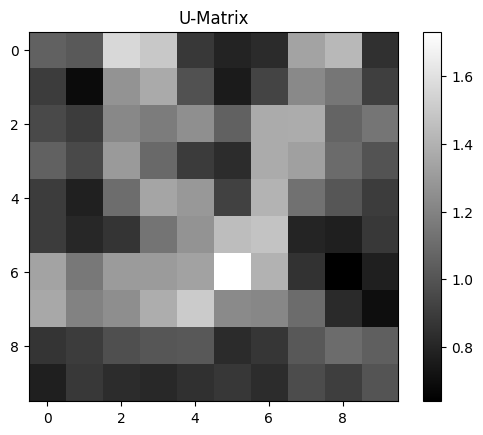

In [191]:
# Calculate and print quantization error for both networks
qe_hex = network.quantization_error(data_hex)
qe_cube = network_3d.quantization_error(data_cube)
print(f'Quantization Error for 2D network: {qe_hex}')
print(f'Quantization Error for 3D network: {qe_cube}')

# Visualize U-Matrix for both networks
print("U-Matrix for 2D network:")
network.u_matrix()

print("U-Matrix for 3D network:")
network_3d.u_matrix()

In [192]:
purity, cluster_ids = network.cluster_purity(data_hex)
print("Czystość klastrów dla danych hexagon: ", purity)
print("Przypisane identyfikatory klastrów: ", cluster_ids)

Czystość klastrów dla danych hexagon:  0.07833333333333334
Przypisane identyfikatory klastrów:  {(0, 0): None, (0, 1): None, (0, 2): None, (0, 3): None, (0, 4): None, (0, 5): None, (0, 6): None, (0, 7): None, (0, 8): None, (0, 9): None, (0, 10): None, (0, 11): None, (0, 12): None, (0, 13): None, (0, 14): None, (0, 15): None, (0, 16): None, (0, 17): None, (0, 18): None, (0, 19): None, (1, 0): None, (1, 1): None, (1, 2): None, (1, 3): None, (1, 4): None, (1, 5): None, (1, 6): None, (1, 7): None, (1, 8): None, (1, 9): None, (1, 10): None, (1, 11): None, (1, 12): None, (1, 13): None, (1, 14): None, (1, 15): None, (1, 16): None, (1, 17): None, (1, 18): None, (1, 19): None, (2, 0): None, (2, 1): None, (2, 2): None, (2, 3): None, (2, 4): None, (2, 5): None, (2, 6): None, (2, 7): None, (2, 8): None, (2, 9): None, (2, 10): None, (2, 11): None, (2, 12): None, (2, 13): None, (2, 14): None, (2, 15): None, (2, 16): None, (2, 17): None, (2, 18): None, (2, 19): None, (3, 0): None, (3, 1): None, (3, 2